# Solving an inverse Problem with TorchPhysics and PINNs: Example 7
We consider now the wave equation

\begin{align*}
    \partial_t^2 u &= c \, \partial_x^2 u, &&\text{ in } I_x \times I_t, \\
    u &= 0 , &&\text{ on } \partial I_x \times I_t, \\
    (\partial_t u)(\cdot, 0) &= 0 , &&\text{ in } I_x, \\
    u(\cdot, 0) &= \sin(x) , &&\text{ in } I_x,
\end{align*}

with $I_x = [0, 2\pi]$ and $I_t = [0, 5]$. We are given a noisy dataset $\{(u_i, x_i, t_i)\}_{i=1}^N$ and aim to determine the corresponding value of $c$. 

The data condition already enforces the correct shape of $u$, including boundary and initial conditions. Since $c$ is exclusively present in the PDE loss, we decide to not include the boundary and initial conditions as additional loss terms but train only PDE and data condition.

In [ ]:
!pip install torchaudio==0.13.0
!pip install torchvision==0.14.0
!pip install torchphysics

In [1]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math

# Here all parameters are defined:
t_min, t_max = 0.0, 5.0
x_min, x_max = 0.0, 2 * math.pi 

# Number of training points 
N_pde = 20000

# Training parameters
train_iterations = 5000
learning_rate = 1.e-3

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
### TODO: Implement the spaces
X = tp.spaces.R1('x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
C = tp.spaces.R1('c')

### TODO: Define the domain omega and time interval 
I_x = tp.domains.Interval(space=X, lower_bound=x_min, upper_bound=x_max)
I_t = tp.domains.Interval(space=T, lower_bound=t_min, upper_bound=t_max)

### TODO: Create sampler for the PDE condition inside I_x x I_t
pde_sampler = tp.samplers.RandomUniformSampler(domain=I_x * I_t, n_points=N_pde)

In [3]:
### TODO: Create the neural networks for the solution u and the learnable parameter c.
###       The model of u should contain 3 hidden layers with 50 neurons each and should have
###       X*T as an input space (order is important for the following cells).
###       For the parameter c use `tp.models.Parameter`
model_u = tp.models.FCN(input_space=X*T, output_space=U, hidden = (50,50,50))
param_C = tp.models.Parameter(init=1.0, space=C)

In [4]:
### TODO: Define condition for the PDE:
def pde_residual(c, u, t, x):
    return tp.utils.laplacian(u, t) - c * tp.utils.laplacian(u, x)

pde_condition = tp.conditions.PINNCondition(model_u, pde_sampler, pde_residual, parameter=param_C)

In [ ]:
### Here, we load the data. First download it from GitHub and then read it with
### PyTorch. `in_data` contains combinations of X*T points and 'out_data' the 
### coressponding ampltidue of the wave.

!wget https://github.com/TomF98/torchphysics/raw/main/examples/SolutionData/Ex_7/wave_in_data.pt
!wget https://github.com/TomF98/torchphysics/raw/main/examples/SolutionData/Ex_7/wave_out_data.pt

In [18]:
out_data = torch.load('wave_out_data.pt')
in_data = torch.load('wave_in_data.pt')

In [19]:
### TODO: add 1% random noise to the output data. Hint: torch.rand_like(a) creates random uniformr noise with the same shape etc. as a

out_data += 0.01 * torch.randn_like(out_data) * torch.max(out_data)

In [8]:
### TODO: Transform the data from the previous cell into `tp.spaces.Points` objects, to
###       assign them a space and enable TorchPhysics to work with them:
in_data_points = tp.spaces.Points(in_data, X*T)
out_data_points = tp.spaces.Points(out_data, U)

### Here we create a DataLoader, that passes the above data to the conditions and
### also controls the batch size, the device (CPU or GPU) and more...
data_loader = tp.utils.PointsDataLoader((in_data_points, out_data_points), batch_size=len(in_data))

A DataCondition minimizes the distance between the outputs of the NN and given data points.

In [9]:
### TODO: Complete the data condtion given below, by inserting the missing 
###       keywords.
data_condition = tp.conditions.DataCondition(module=model_u,
                                             dataloader=data_loader,
                                             norm=2, use_full_dataset=True,
                                             weight=50) 

First, we optimize using the Adam optimizer.

In [10]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition, pde_condition], optimizer_setting=optim)


trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_steps=train_iterations,
                     logger=False,
                     benchmark=True)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Optional: try to improve the results by using LBFGS, a second-order optimizer that works only with constant inputs in every iteration.

In [11]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, optimizer_args={'max_iter': 3})
pde_condition.sampler = pde_condition.sampler.make_static()
solver = tp.solver.Solver([pde_condition, data_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_steps=1000,
                     logger=False,
                     benchmark=True)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.3 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
print("Correct value of c is: 0.742")
print("With PINNs we computed the value:", param_C.as_tensor.item())
print("Relative difference is:", abs(0.742 - param_C.as_tensor.item()) / 0.742)

Correct value of c is: 0.742
With PINNs we computed the value: 0.7313588261604309
Relative difference is: 0.01434120463553785


/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: C

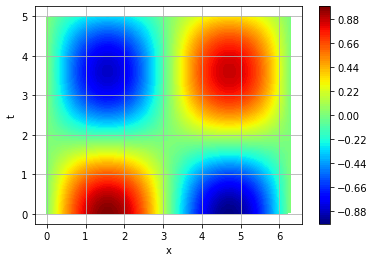

In [13]:
### We can also plot the solution that we learned
plot_domain = tp.domains.Parallelogram(X*T, [0, 0], [x_max, 0], [0, t_max])
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, plot_type="contour_surface")

MovieWriter ffmpeg unavailable; using Pillow instead.


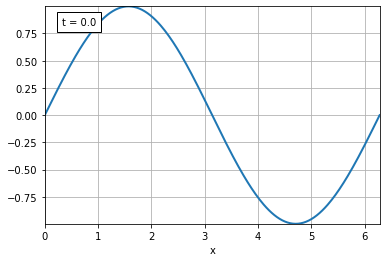

In [14]:
# Or an animation:
anim_sampler = tp.samplers.AnimationSampler(I_x, I_t, 200, n_points=250)
fig, anim = tp.utils.animate(model_u, lambda u: u, anim_sampler, ani_speed=40)
anim.save('wave-eq.gif')
# On Google colab you have at the left side a tab with a folder. There you should find the gif and can watch it.